# Auto encoders

This notebook introduces the concept of auto-encoders. These are neural networks that output their input. This does not seem overaly useful at first, however the network contains a bottle neck. This means that the network can not just learn the identity (copy inputs to outputs) but needs to find a way to represent the inputs using much less information and then recreate the original inputs from that representation.

This is a good example of neural networks being feature transformers. They transform your images from a pixel representation to a smaller one that represents the same information. Similar maybe to a compression algorithm.

This notebook is based on the examples in https://blog.keras.io/building-autoencoders-in-keras.html. Follow along there as well for ideas on things to try.

In [1]:
%config InlineBackend.figure_format='retina'
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (8, 8)
plt.rcParams["font.size"] = 14
from sklearn.utils import check_random_state

## Auto-encoders

Create a simple Auto Encoder using `keras`. By forcing the input through a bottleneck we can hope that the auto encoder focusses on interesting structure in the data and ignores noise. Maybe auto encoders can be used to perform denoising.

* create your own auto encoder setup. You might have to construct an auto encoder that has more layers or uses more powerful transformations like `Conv2D`, `MaxPooling2D` and `Upsampling2D`. Start with a simple one first for debugging though.
* make sure to load the MNIST dataset from `keras` and not the digits dataset from scikit-learn.
* Create a noisy version of your digits by drawing pixel values from a gaussian with mean equal to each pixel's intensity and a small standard deviation (tip: start with little/no noise to debug your auto encoder and then slowly increase the noise)

(Bonus: can you learn an "auto encoder" that rotates clean digits by 90degrees? This shuold start you off thinking about using neural networks as general purpose "transformers".)

In [2]:
from keras.datasets import mnist

# note: the MNIST dataset has more features and more samples than the digits
# dataset in scikit-learn
# Only load the training images, we don't need more and we do not care for the labels
(x_train, y_train), (_, _) = mnist.load_data()
x_train = x_train.reshape(-1, 28*28)

X = x_train / 255

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y_train,
                                                    train_size=0.8, random_state=1)

Using TensorFlow backend.
/Users/thead/anaconda/envs/deep-image-class/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


This is an extremely simple auto-encoder. It has just one fully connected layer. It goes from 782 dimensions to 32 in the hidden layer.

In [3]:
from keras.layers import Input, Dense
from keras.models import Model

# go from 784 dimensions to 32, a reduction of factor 24
encoding_dim = 32

input_img = Input(shape=(784,))
encoded = Dense(encoding_dim, activation='relu')(input_img)
decoded = Dense(784, activation='relu')(encoded)

autoencoder = Model(input_img, decoded)

autoencoder.compile(optimizer='adam', loss='mean_squared_error')

model = autoencoder.fit(X_train, X_train,
                        epochs=50,
                        batch_size=256,
                        shuffle=True,
                        verbose=False,
                        validation_data=(X_test, X_test))

In [4]:
# shortcut to perform just the encoding
encoder = Model(input_img, encoded)

# shortcut to perform just the decoding step
encoded_input = Input(shape=(encoding_dim,))
decoder_layer = autoencoder.layers[-1]
decoder = Model(encoded_input, decoder_layer(encoded_input))

X_encoded = encoder.predict(X_test)
X_decoded = decoder.predict(X_encoded)

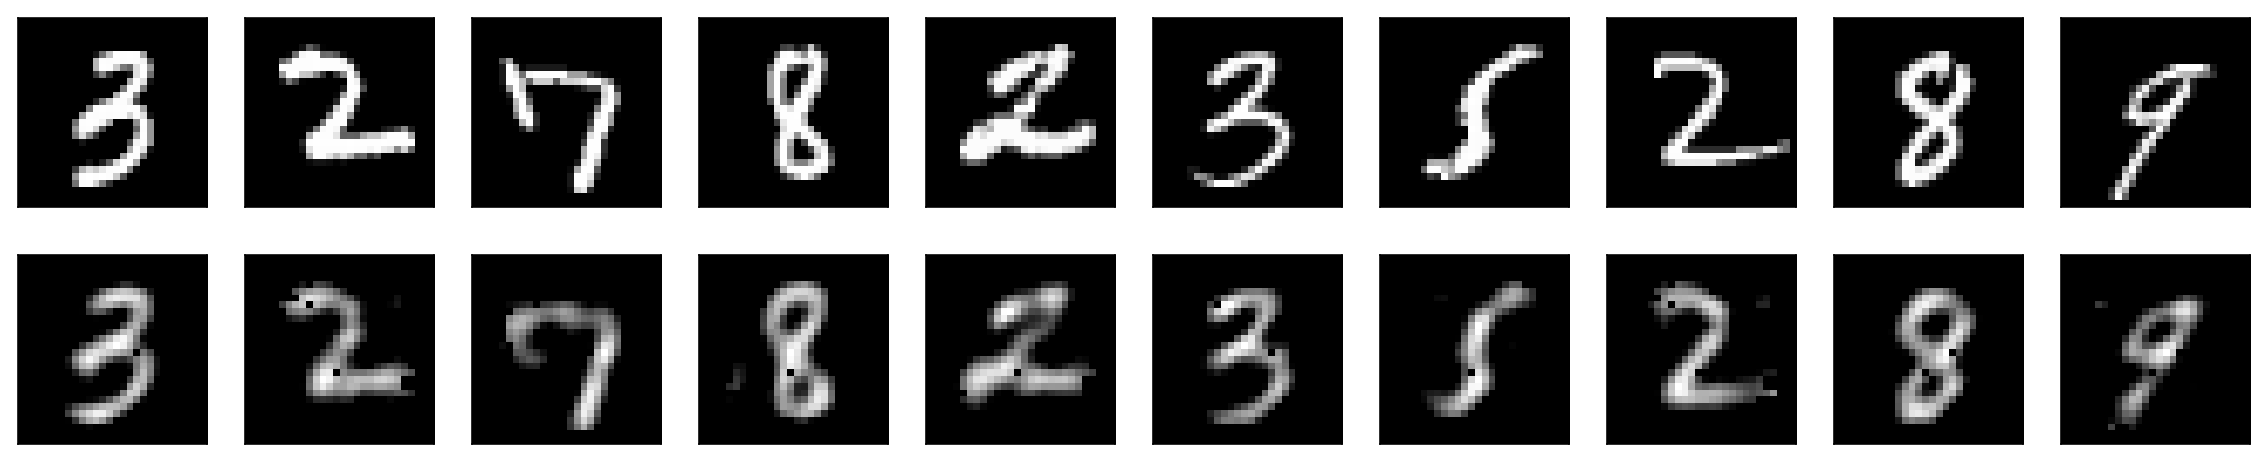

In [5]:
def plot_comparison(original, reconstructed, n=10):
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # original
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(original[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # reconstruction
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(reconstructed[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
plot_comparison(X_test, X_decoded)

In [6]:
X_train_noisy = X_train + 0.05 * np.random.normal(loc=0.0, scale=1., size=X_train.shape)
X_test_noisy = X_test + 0.05 * np.random.normal(loc=0.0, scale=1., size=X_test.shape)

In [7]:
input_img = Input(shape=(784,))
encoded = Dense(encoding_dim, activation='relu')(input_img)
decoded = Dense(784, activation='relu')(encoded)

denoise_autoencoder = Model(input_img, decoded)

denoise_autoencoder.compile(optimizer='adam', loss='mean_squared_error')

denoise_model = denoise_autoencoder.fit(X_train_noisy, X_train,
                                        epochs=50,
                                        batch_size=256,
                                        shuffle=True,
                                        verbose=False,
                                        validation_data=(X_test, X_test))

In [8]:
# shortcut to perform just the encoding
denoise_encoder = Model(input_img, encoded)

# shortcut to perform just the decoding step
encoded_input = Input(shape=(encoding_dim,))
decoder_layer = denoise_autoencoder.layers[-1]
denoise_decoder = Model(encoded_input, decoder_layer(encoded_input))

X_encoded_noisy = denoise_encoder.predict(X_test_noisy)
denoise_X_decoded = denoise_decoder.predict(X_encoded_noisy)

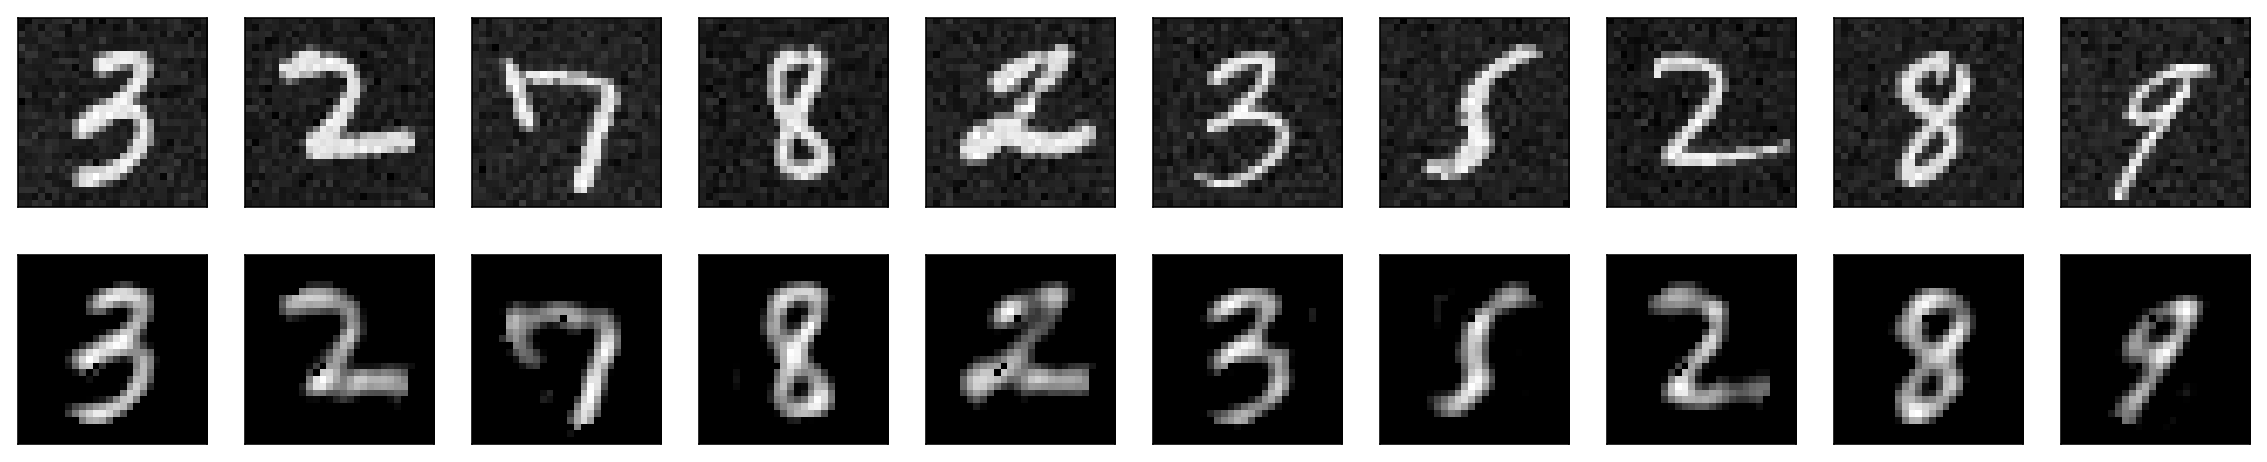

In [9]:
plot_comparison(X_test_noisy, denoise_X_decoded)